# Occurrence of new collaborations

In this notebook, we will analyze the occurrence of new collaborations over the years. We will look at the total number of articles published, the number of articles with new author collaborations, and the number of articles with new institution collaborations. We will also analyze the average collaboration novelty index over the years.

## Brief overview
Collaboration novelty index unexpectedly peaks in 2022. We checked whether this might be due to COVID articles, but that was not the case, so we excluded top and bottom 5% articles and re-drew the plot. The trend of collaboration novelty index is increasing over the years. Approximately half of the articles are new institution collaborations and the majority of articles are new author collaborations, meaning that we will have to better define what constitutes a new collaboration and what events are relevant to our research. 

The overall trend of new institution and author collaborations is increasing over time similarly as the number of total articles published.

### Imports & Global Variables

In [3]:
import numpy as np
from box import Box
from google.cloud import bigquery

In [4]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
client = bigquery.Client(project=config.GCP.PROJECT_ID)
# Set the BigQuery dataset schemab
schema = config.GCP.READ_SCHEMA
# Set numpy random seed
np.random.seed(config.RANDOM_SEED)

### Collaboration Novelty Index Trend

We will query data from the `FCT_COLLABORATION_NOVELTY` table to analyze the average collaboration novelty index over the years.

In [6]:
query = f"""
SELECT EXTRACT(YEAR FROM ARTICLE_PUBLICATION_DT) AS YEAR,
       COLLABORATION_NOVELTY_INDEX          AS COLLABORATION_NOVELTY_INDEX_AVG
FROM {schema}.FCT_COLLABORATION_NOVELTY
"""

df = client.query(query).result().to_dataframe()
df.head(50)

,YEAR,COLLABORATION_NOVELTY_INDEX_AVG
0,2000,7.250000
1,2000,819.000000
2,2000,7.250000
3,2000,26.625000
4,2000,4.666667
5,2000,0.454545
6,2000,36.000000
7,2000,0.100000
8,2000,0.486486
9,2000,0.083333


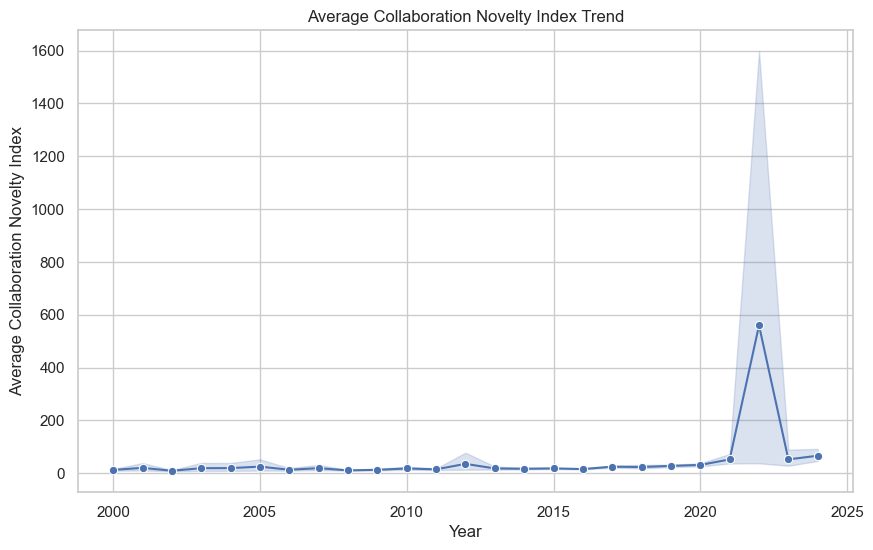

In [7]:

# Plot the average collaboration novelty index trend
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='YEAR', y='COLLABORATION_NOVELTY_INDEX_AVG', marker='o')
plt.title('Average Collaboration Novelty Index Trend')
plt.xlabel('Year')
plt.ylabel('Average Collaboration Novelty Index')
plt.show()


**Check if the increase in collaboration novelty index is due to COVID articles**

In [9]:
# Get maximum 100 values by collaboration novelty index (from 2022) including article name
query = f"""
SELECT A.ARTICLE_TITLE,
       C.COLLABORATION_NOVELTY_INDEX
FROM {schema}.FCT_COLLABORATION_NOVELTY C
INNER JOIN {schema}.DIM_ARTICLE A USING (ARTICLE_SID)
WHERE EXTRACT(YEAR FROM C.ARTICLE_PUBLICATION_DT) = 2022
ORDER BY C.COLLABORATION_NOVELTY_INDEX DESC
LIMIT 100
"""

df = client.query(query).result().to_dataframe()

In [11]:
# Count the number of articles with 'SARS', 'CoV', 'COVID' or 'epidemic' in the title
df['ARTICLE_TITLE'] = df['ARTICLE_TITLE'].str.lower()

# Print count
covid_article_count = df[df['ARTICLE_TITLE'].str.contains('sars|cov|covid|epidemic')].shape[0]
print(f"COVID Articles: {covid_article_count:.0f}")
# Print average collaboration novelty index
cni_mean = df['COLLABORATION_NOVELTY_INDEX'].mean()
print(f"Average Collaboration Novelty Index: {cni_mean:.2f}")
# Print average collaboration novelty index for COVID articles
cni_covid_mean = df[df['ARTICLE_TITLE'].str.contains('sars|cov|covid|epidemic')]['COLLABORATION_NOVELTY_INDEX'].mean()
print(f"Average Collaboration Novelty Index for COVID Articles: {cni_covid_mean:.2f}")
# Print average collaboration novelty index for bottom 95% articles
cni_q_95 = df['COLLABORATION_NOVELTY_INDEX'].quantile(0.95)
print(f"Average Collaboration Novelty Index for Bottom 95% Articles: {cni_q_95:.2f}")
df.head(10)

COVID Articles: 18
Average Collaboration Novelty Index: 111658.50
Average Collaboration Novelty Index for COVID Articles: 7757.92
Average Collaboration Novelty Index for Bottom 95% Articles: 28749.37


,ARTICLE_TITLE,COLLABORATION_NOVELTY_INDEX
0,operation and performance of the atlas semicon...,1.058149e+07
1,nationwide outcomes of octogenarians following...,1.064722e+05
2,the evolving sars-cov-2 epidemic in africa: in...,8.785261e+04
3,first joint observation by the underground gra...,6.900579e+04
4,clinical presentation and short- and long-term...,3.591000e+04
5,global climate,2.837250e+04
6,review of particle physics,1.557319e+04
7,correction: evolving trends in the management ...,1.114373e+04
8,pharmaceutical pollution of the world’s rivers,1.066800e+04
9,standards of care for the health of transgende...,1.053150e+04


In [13]:
## Exclude bottom and top 5% articles and redraw the plot

query = f"""
SELECT EXTRACT(YEAR FROM C.ARTICLE_PUBLICATION_DT) AS YEAR,
       C.COLLABORATION_NOVELTY_INDEX
FROM {schema}.FCT_COLLABORATION_NOVELTY C
"""

df = client.query(query).result().to_dataframe()

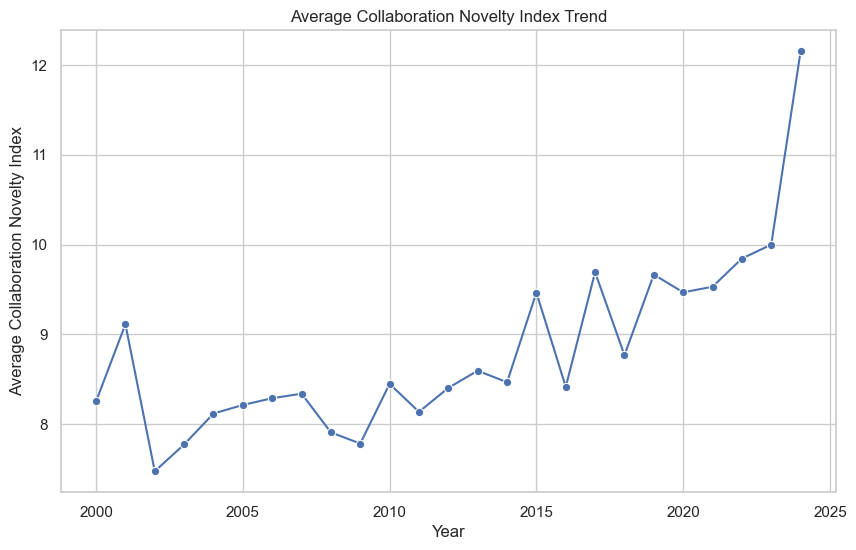

In [14]:
df = df[(df['COLLABORATION_NOVELTY_INDEX'] > df['COLLABORATION_NOVELTY_INDEX'].quantile(0.05)) & (
        df['COLLABORATION_NOVELTY_INDEX'] < df['COLLABORATION_NOVELTY_INDEX'].quantile(0.95))]

# Calculate the average collaboration novelty index by year
df = df.groupby('YEAR').agg({'COLLABORATION_NOVELTY_INDEX': 'mean'}).reset_index()

# Plot the average collaboration novelty index trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='YEAR', y='COLLABORATION_NOVELTY_INDEX', marker='o')
plt.title('Average Collaboration Novelty Index Trend')
plt.xlabel('Year')
plt.ylabel('Average Collaboration Novelty Index')
plt.show()


### Occurrence of New Collaborations Trend

We will query data from the `FCT_COLLABORATION` table to analyze the occurrence of new collaborations over the years. We will look at the total number of articles published, the number of articles with new author collaborations, and the number of articles with new institution collaborations.

In [16]:
query = f"""
SELECT EXTRACT(YEAR FROM ARTICLE_PUBLICATION_DT)                               AS YEAR,
       COUNT(DISTINCT ARTICLE_SID)                                             AS ARTICLE_COUNT,
       COUNT(DISTINCT IF(IS_NEW_AUTHOR_COLLABORATION, ARTICLE_SID, NULL))      AS NEW_AUTHOR_COLLABORATION_COUNT,
       COUNT(DISTINCT IF(IS_NEW_INSTITUTION_COLLABORATION, ARTICLE_SID, NULL)) AS NEW_INSTITUTION_COLLABORATION_COUNT
FROM {schema}.FCT_COLLABORATION
WHERE IS_ARTICLE_RELEVANT
  AND EXTRACT(YEAR FROM ARTICLE_PUBLICATION_DT) >= 2000
GROUP BY 1
ORDER BY 1 ASC;
"""

df = client.query(query).result().to_dataframe()
df.head(50)

,YEAR,ARTICLE_COUNT,NEW_AUTHOR_COLLABORATION_COUNT,NEW_INSTITUTION_COLLABORATION_COUNT
0,2000,921,757,324
1,2001,971,773,373
2,2002,1061,834,370
3,2003,1165,942,434
4,2004,1394,1113,479
5,2005,1585,1264,538
6,2006,1761,1428,612
7,2007,1860,1499,650
8,2008,2233,1788,810
9,2009,2558,2029,876


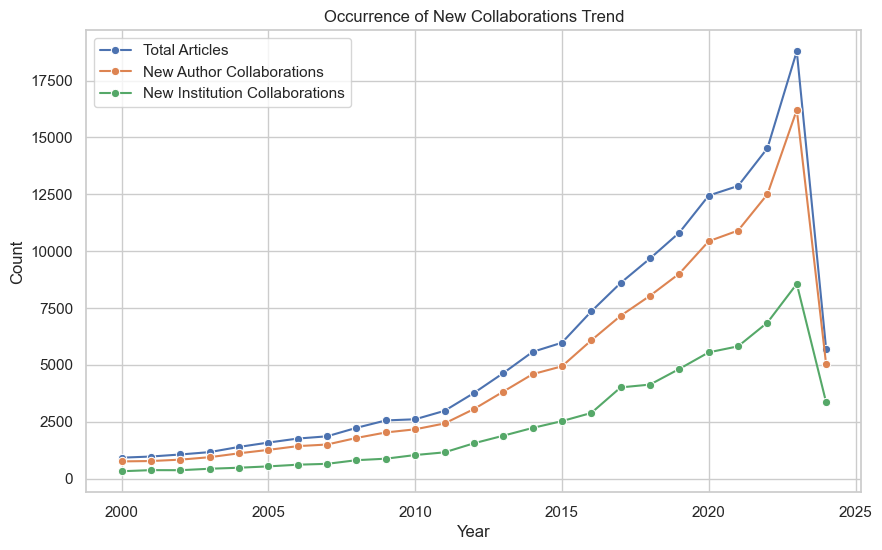

In [17]:
# Plot the occurrence of new collaborations trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='YEAR', y='ARTICLE_COUNT', marker='o', label='Total Articles')
sns.lineplot(data=df, x='YEAR', y='NEW_AUTHOR_COLLABORATION_COUNT', marker='o', label='New Author Collaborations')
sns.lineplot(data=df, x='YEAR', y='NEW_INSTITUTION_COLLABORATION_COUNT', marker='o',
             label='New Institution Collaborations')
plt.title('Occurrence of New Collaborations Trend')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()